<a href="https://colab.research.google.com/github/MNeilDiane/Augustine/blob/master/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id '1KSFIRh0-_Vr7SdiSCZP1ItV7bXPxMD92' --output data.tar.gz
!tar -zxvf data.tar.gz
!ls

Downloading...
From: https://drive.google.com/uc?id=1KSFIRh0-_Vr7SdiSCZP1ItV7bXPxMD92
To: /content/data.tar.gz
100% 6.11M/6.11M [00:00<00:00, 25.7MB/s]
data/
data/sample_submission.csv
data/test_no_label.csv
data/train.csv
data/X_test
data/X_train
data/Y_train
data  data.tar.gz  sample_data


In [ ]:
import numpy as np

np.random.seed(0)#相同的seed，每次生成的随机数相同。
X_train_fpath = './data/X_train'
Y_train_fpath = './data/Y_train'
X_test_fpath = './data/X_test'
output_fpath = './output_{}.csv'#接受结果 

# 把csv文件转换成numpy的数组
with open(X_train_fpath) as f:
    next(f)#跳过第一行，从第二行数据开始读取
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)# #截取每行下标为1到最后的列，删除掉每行数据中的换行符，遇到','分割数据
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)


In [ ]:
#定义一个标准化函数_normalize()
#X：待处理的矩阵，处理后作为返回值
#train:bool变量，标记输入是否为test集
#specified_column：定义了需要被标准化的列。如果输入为None，则表示所有列都需要被标准化。
#X_mean：训练集中每一列的均值
#X_std：训练集中每一列的方差
def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
  if specified_column == None:
    specified_column = np.arange(X.shape[1])
  if train:
    X_mean = np.mean(X[:,specified_column],0).reshape(1,-1)#axis = 0：压缩行，对各列求均值，返回 1×n 矩阵 reshape(1,-1)转换为一行
    X_std = np.std(X[:,specified_column],0).reshape(1,-1)
  X[:,specified_column] = (X[:,specified_column] - X_mean)/(X_std+1e-8)
  return X,X_mean,X_std
  # This function normalizes specific columns of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # Arguments:
    #     X: data to be processed
    #     train: 'True' when processing training data, 'False' for testing data
    #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
    #         will be normalized.
    #     X_mean: mean value of training data, used when train = 'False'
    #     X_std: standard deviation of training data, used when train = 'False'
    # Outputs:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data
#标准化训练数据与测试数据
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)



In [ ]:
#分割训练集与验证集
def _train_dev_split(X, Y, dev_ratio = 0.25):
  # This function spilts data into training set and development set.
  train_size = int(len(X)*(1-dev_ratio))#train size
  return X[:train_size],Y[:train_size],X[train_size:],Y[train_size:]#划分出测试集与验证集

dev_ratio = 0.1#9：1
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio = dev_ratio)
train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))


Size of training set: 48830
Size of development set: 5426
Size of testing set: 27622
Dimension of data: 510


In [ ]:
#_shuffle(X,Y)：X和Y是两个数组，如果分别随机打乱X和Y，那么X和Y的对应关系就会被破坏。所以，这里生成行的编号，对行的编号进行打乱，就可以获得一一对应的打乱后的X和Y.
#_sigmoid(z)：σ ( z ) \sigma(z)σ(z)函数
#_f(X,w,b)：Logistic Regression的函数f w , b ( X ) = σ ( w ⋅ X + b ) 参数是权重w和偏差b
#_predict(X,w,b)
def _shuffle(X,Y):
  # This function shuffles two equal-length list/array, X and Y, together.
  randomize = np.arange(len(X))
  np.random.shuffle(randomize)
  return (X[randomize],Y[randomize])
def _sigmoid(z):
  # Sigmoid function can be used to calculate probability.
  # To avoid overflow, minimum/maximum output value is set.
  return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))#取a数组中的闭区间[a_min, a_max]，数组中小于a_min的数都变成a_min，大于a_max的数都变成a_max

def _f(X,w,b):
    # This is the logistic regression function, parameterized by w and b
    #
    # Arguements:
    #     X: input data, shape = [batch_size, data_dimension]
    #     w: weight vector, shape = [data_dimension, ]
    #     b: bias, scalar
    # Output:
    #     predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    return _sigmoid(np.matmul(X, w)+b)#np.matual用于矩阵相乘

def _predict(X,w,b):
  return np.round(_f(X,w,b)).astype(np.int)#用于取整，四舍五入。除了个位以0结尾的数外，该种数一律向下取整.

def _accuracy(Y_pred,Y_label):
  acc = 1-np.mean(np.abs(Y_pred-Y_label))
  return acc


In [ ]:
#损失函数
def _cross_entropy_loss(y_pred,Y_label):
  # This function computes the cross entropy.
    #
    # Arguements:
    #     y_pred: probabilistic predictions, float vector
    #     Y_label: ground truth labels, bool vector
    # Output:
    #     cross entropy, scalar
    cross_entropy = -np.dot(Y_label,np.log(y_pred)) - np.dot((1-Y_label),np.log(1 - y_pred))
    return cross_entropy


In [ ]:
#gradient
def _gradient(X,Y_label,w,b):
  # This function computes the gradient of cross entropy loss with respect to weight w and bias b.
  y_pred = _f(X,w,b)
  pred_error = Y_label - y_pred
  w_grad = -np.sum(pred_error*X.T,1)
  b_grad = -np.sum(pred_error)
  return w_grad,b_grad

In [ ]:
# 初始化权重w和b，令它们都为0
w = np.zeros((data_dim,))	#[0,0,0,...,0]
b = np.zeros((1,))		 	#[0]

# 训练时的超参数
max_iter = 10
batch_size = 8
learning_rate = 0.2

# 保存每个iteration的loss和accuracy，以便后续画图
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# 累计参数更新的次数
step = 1

# 迭代训练
for epoch in range(max_iter):
    # 在每个epoch开始时，随机打散训练数据
    X_train, Y_train = _shuffle(X_train, Y_train)
        
    # Mini-batch训练
    for idx in range(int(np.floor(train_size / batch_size))):#np.floor()返回不大于输入参数的最大整数
        X = X_train[idx*batch_size:(idx+1)*batch_size]
        Y = Y_train[idx*batch_size:(idx+1)*batch_size]

        # 计算梯度
        w_grad, b_grad = _gradient(X, Y, w, b)
            
        # 梯度下降法更新
        # 学习率随时间衰减
        w = w - learning_rate/np.sqrt(step) * w_grad
        b = b - learning_rate/np.sqrt(step) * b_grad

        step = step + 1
            
    # 计算训练集和验证集的loss和accuracy
    y_train_pred = _f(X_train, w, b)
    Y_train_pred = np.round(y_train_pred)#四舍五入
    train_acc.append(_accuracy(Y_train_pred, Y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, Y_train) / train_size)

    y_dev_pred = _f(X_dev, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_acc.append(_accuracy(Y_dev_pred, Y_dev))
    dev_loss.append(_cross_entropy_loss(y_dev_pred, Y_dev) / dev_size)

print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))







Training loss: 0.27135543524640593
Development loss: 0.2896359675026287
Training accuracy: 0.8836166291214418
Development accuracy: 0.8733873940287504


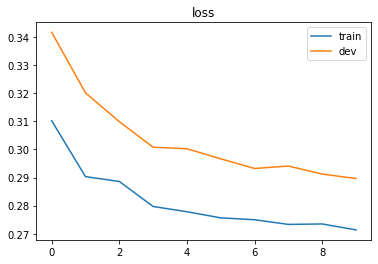

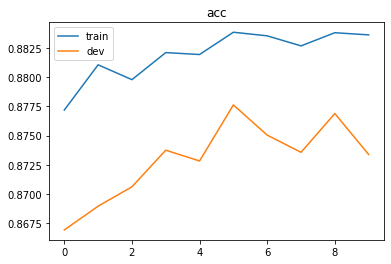

In [ ]:
import matplotlib.pyplot as plt
#loss曲线
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('loss')
plt.legend(['train','dev'])
plt.savefig('loss.png')
plt.show()
#accuracy曲线
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('acc')
plt.legend(['train','dev'])
plt.savefig('acc.png')
plt.show()

In [ ]:
#test
#预测测试集标签
predictions = _predict(X_test,w,b)
with open(output_fpath.format('logistic'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):#enumerate(predictions) 可以既遍历出predictions的索引，又遍历出元素
        f.write('{},{}\n'.format(i, label))

# 输出最重要的特征和权重
# 对w的绝对值从大到小排序，输出对应的ID
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
  content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
  print(features[i],w[i])



 Not in universe -4.031960278019251
 Spouse of householder -1.625403958705141
 Other Rel <18 never married RP of subfamily -1.4195759775765404
 Child 18+ ever marr Not in a subfamily -1.2958572076664745
 Unemployed full-time 1.1712558285885912
 Other Rel <18 ever marr RP of subfamily -1.167791807296237
 Italy -1.093458143800618
 Vietnam -1.0630365633146415
num persons worked for employer 0.938992277356651
 1 0.8226614922117185


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
